In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
TRAINING_SAMPLE = 200000
VALIDATE_SIZE = 0.2
RANDOM_SEED = 2021 
RATIO_TO_FRAUD = 15
LABELS = ["Normal","Fraud"]

Init Plugin
Init Graph Optimizer
Init Kernel


The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise. Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [72]:
dataset = pd.read_csv("creditcard.csv")
#Exploratory Data Analysis
#check for any null values 
print("Any nulls in the dataset ",dataset.isnull().values.any() )
print('-------')
print("No. of unique labels ", len(dataset['Class'].unique()))
print("Label values ", dataset.Class.unique())
#0 is for normal credit card transaction
#1 is for fraudulent credit card transaction
print('-------')
print("Break down of the Normal and Fraud Transactions")
count_classes = pd.value_counts(dataset['Class'], sort = True)
print(count_classes)
dataset

Any nulls in the dataset  False
-------
No. of unique labels  2
Label values  [0 1]
-------
Break down of the Normal and Fraud Transactions
0    284315
1       492
Name: Class, dtype: int64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [73]:
dataset["logAmount"] = np.log10(dataset["Amount"]+1e-8)

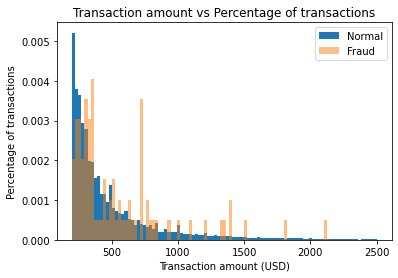

In [74]:
# Save the normal and fradulent transactions in separate dataframe
normal_dataset = dataset[dataset.Class == 0] 
fraud_dataset = dataset[dataset.Class == 1]
#Visualize transactionamounts for normal and fraudulent transactions
bins = np.linspace(200, 2500, 100)
plt.hist(normal_dataset.Amount, bins=bins, alpha=1, density=True, label='Normal')
plt.hist(fraud_dataset.Amount, bins=bins, alpha=0.5, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Transaction amount vs Percentage of transactions")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions")
plt.show()

In [75]:
normal_dataset.drop(['Time', 'Amount'], axis=1, inplace=True)
fraud_dataset.drop(['Time', 'Amount'], axis=1, inplace=True)
# shuffle our training set
clean = normal_dataset.sample(frac=1).reset_index(drop=True)
# training set: exlusively non-fraud transactions
X_train = clean.iloc[:TRAINING_SAMPLE].drop('Class', axis=1)
# testing  set: the remaining non-fraud + all the fraud 
X_test = pd.concat([clean.iloc[TRAINING_SAMPLE:], fraud_dataset.sample(frac=1)])

from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# train // validate - no labels since they're all clean anyway
X_train, X_validate = train_test_split(X_train, 
                                       test_size=VALIDATE_SIZE, 
                                       random_state=RANDOM_SEED)

# manually splitting the labels from the test df
X_test, y_test = X_test.drop('Class', axis=1).values, X_test.Class.values.astype(bool)
# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])
# get normalization parameters by fitting to the training data
pipeline.fit(X_train)
# transform the training and validation data with these parameters
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)

/var/folders/50/zx6p2vtx3h9bvdft7b3h85sm0000gn/T/ipykernel_14941/1289212600.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_dataset.drop(['Time', 'Amount'], axis=1, inplace=True)
/var/folders/50/zx6p2vtx3h9bvdft7b3h85sm0000gn/T/ipykernel_14941/1289212600.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_dataset.drop(['Time', 'Amount'], axis=1, inplace=True)


In [76]:
print(f"""Shape of the datasets:
    training (rows, cols) = {X_train.shape}
    validate (rows, cols) = {X_validate.shape}
    holdout  (rows, cols) = {X_test.shape}""")

Shape of the datasets:
    training (rows, cols) = (160000, 29)
    validate (rows, cols) = (40000, 29)
    holdout  (rows, cols) = (84807, 29)


In [80]:
# data dimensions // hyperparameters 
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 256
EPOCHS = 100

# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([    
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),    
    # reconstruction / decode
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')    
])

In [81]:
#Define the callbacks for checkpoints and early stopping
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.h5",
                                        mode='min', monitor='val_loss',                                        
                                        verbose=0, save_best_only=True)
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True)
#Compile the Autoencoder
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
#Train the Autoencoder
history = autoencoder.fit(X_train_transformed, X_train_transformed,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_data=(X_validate_transformed, X_validate_transformed),
                    verbose=1,
                    callbacks=[cp, early_stop]
                    ).history

Epoch 1/100


2022-05-22 18:43:21.401337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


622/625 [============================>.] - ETA: 0s - loss: 0.0264 - accuracy: 0.2395

2022-05-22 18:43:32.189258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 12s 18ms/step - loss: 0.0263 - accuracy: 0.2397 - val_loss: 0.0153 - val_accuracy: 0.2992
Epoch 2/100
625/625 [==============================] - 11s 17ms/step - loss: 0.0147 - accuracy: 0.3362 - val_loss: 0.0145 - val_accuracy: 0.3387
Epoch 3/100
625/625 [==============================] - 11s 17ms/step - loss: 0.0145 - accuracy: 0.3323 - val_loss: 0.0144 - val_accuracy: 0.3410
Epoch 4/100
625/625 [==============================] - 11s 17ms/step - loss: 0.0143 - accuracy: 0.3307 - val_loss: 0.0142 - val_accuracy: 0.3372
Epoch 5/100
625/625 [==============================] - 11s 17ms/step - loss: 0.0140 - accuracy: 0.3471 - val_loss: 0.0139 - val_accuracy: 0.3516
Epoch 6/100
625/625 [==============================] - 11s 17ms/step - loss: 0.0139 - accuracy: 0.3517 - val_loss: 0.0138 - val_accuracy: 0.3540
Epoch 7/100
625/625 [==============================] - 11s 18ms/step - loss: 0.0138 - accuracy: 0.3472 - val_loss: 0.0137 - val_accuracy: 0.34

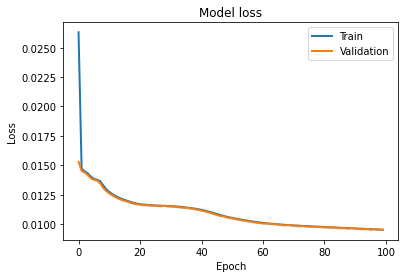

In [82]:
#Plot training and test loss
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Validation')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

/Users/tomxu/miniforge3/envs/tf25/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(


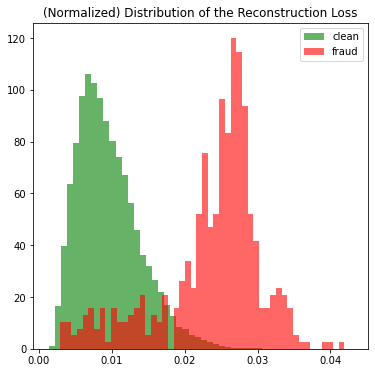

In [87]:
#Anomalies are data points where the reconstruction loss is higher
#To calculate the reconstruction loss on test data, predict the test data and calculate 
#the mean square error between the test data and the reconstructed test data.
X_test_transformed = pipeline.transform(X_test)
test_x_predictions = autoencoder.predict(X_test_transformed)
mse = np.mean(np.power(X_test_transformed - test_x_predictions, 2), axis=1)
clean = mse[y_test==0]
fraud = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

Normally, in an unsupervised solution, this is where the story would end. We would set a threshold that limits the amount of false positives to a manageable degree, and captures the most anomalous data points.

Percentiles: We could set this threshold by taking the top x% of the dataset and considering it anomalous.

MAD: We could also use a modified Z-score using the Median Absolute Deviation to define outliers on our reconstruction data. Here is a good blog post on the topic by João Rodrigues, illustrating why this algorithm is more robust and scalable than the percentiles method.

In [88]:
# modified Z-scores with an absolute value of greater than 3.5 be labeled as potential outliers.
THRESHOLD = 3

def mad_score(points):
    """https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD

print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

Detected 1,534 outliers in a total of 84,807 transactions [1.81%].


In [90]:
from sklearn.metrics import precision_recall_curve

# get (mis)classification
cm = confusion_matrix(y_test, outliers)

# true/false positives/negatives
(tn, fp, fn, tp) = cm.flatten()

print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:{cm}

% of transactions labeled as fraud that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
% of fraudulent transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")

The classifications using the MAD method with threshold=3 are as follows:[[83155  1160]
 [  118   374]]

% of transactions labeled as fraud that were correct (precision): 374/(1160+374) = 24.38%
% of fraudulent transactions were caught succesfully (recall):    374/(118+374) = 76.02%


Generally speaking, you will have to prioritise what you find more important. This dilemma is commonly called the "recall vs precision" trade-off. If you want to increase recall, adjust the MAD's Z-Score threshold downwards, if you want recover precision, increase it.

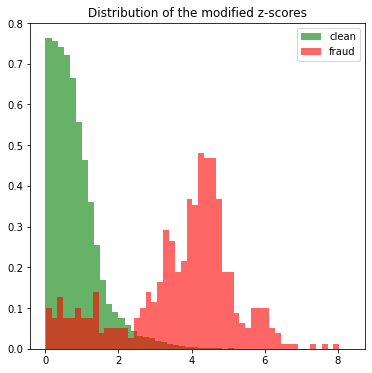

In [91]:
clean = z_scores[y_test==0]
fraud = z_scores[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("Distribution of the modified z-scores")
plt.legend()
plt.show()

In [92]:
encoder = tf.keras.models.Sequential(autoencoder.layers[:5])
encoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 29)                870       
_________________________________________________________________
dense_31 (Dense)             (None, 16)                480       
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_33 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 10        
Total params: 1,532
Trainable params: 1,532
Non-trainable params: 0
_________________________________________________________________


In [94]:
# taking all the fraud, undersampling clean
fraud = X_test_transformed[y_test==1]
clean = X_test_transformed[y_test==0][:len(fraud) * RATIO_TO_FRAUD, ]
# combining arrays & building labels
features = np.append(fraud, clean, axis=0)
labels = np.append(np.ones(len(fraud)),
                   np.zeros(len(clean)))
# getting latent space representation
latent_representation = encoder.predict(features)
print(f'Clean transactions downsampled from {len(X_test_transformed[y_test==0]):,} to {len(clean):,}.')
print('Shape of latent representation:', latent_representation.shape)

2022-05-22 19:35:34.916479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Clean transactions downsampled from 84,315 to 7,380.
Shape of latent representation: (7872, 2)


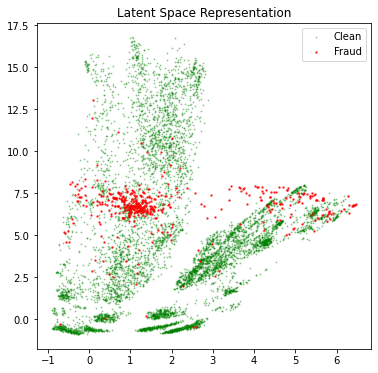

In [99]:
X = latent_representation[:,0]
y = latent_representation[:,1]
# plotting
plt.subplots(figsize=(6, 6))
plt.scatter(X[labels==0], y[labels==0], s=1, c='g', alpha=0.3, label='Clean')
plt.scatter(X[labels==1], y[labels==1], s=2, c='r', alpha=0.7, label='Fraud')
# labeling
plt.legend(loc='best')
plt.title('Latent Space Representation')
# saving & displaying
plt.savefig('latent_representation_2d')
plt.show()

In [98]:
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_test})
print(error_df.dtypes)
error_df

Reconstruction_error    float64
True_class                 bool
dtype: object


,Reconstruction_error,True_class
0,0.008838,False
1,0.012526,False
2,0.003689,False
3,0.014260,False
4,0.006678,False
...,...,...
84802,0.027903,True
84803,0.014851,True
84804,0.026547,True
84805,0.006099,True


In [ ]:
#Plotting the test data points and their respective reconstruction error sets a threshold 
# value to visualize if the threshold value needs to be adjusted.
threshold_fixed = 50
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

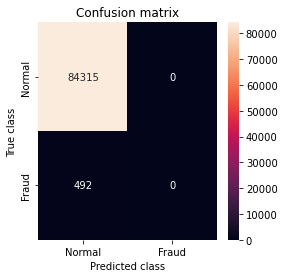

 Accuracy:  0.9941985920973505
 Recall:  0.0
 Precision:  0.0


/Users/tomxu/miniforge3/envs/tf25/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [107]:
#Detect anomalies as points where the reconstruction loss is greater than a fixed threshold. 
#Here we see that a value of 52 for the threshold will be good.
#Evaluating the performance of the anomaly detection
threshold_fixed =52
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df['True_class'], error_df['pred']))
print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))